# Define Dependencies

In [5]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import matplotlib
%matplotlib inline

In [6]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


# Define the neccesary functions for later use

In [31]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def reports (X_test,y_test):
    global y_pred
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy,score


def applyPCA(X, numPCAcomponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numPCAcomponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numPCAcomponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [8]:
X_test = np.load("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


y_test = np.load("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


In [9]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [10]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [11]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

2563/2563 [==============================] - 4s 2ms/step


# Build the Classification Maps

In [12]:
# load the original image
X, y = loadIndianPinesData()

In [13]:
X,pca = applyPCA(X,numPCAcomponents)

In [14]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [15]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = y[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = prediction+1

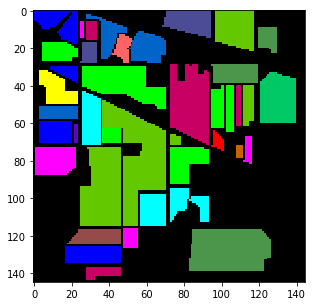

In [16]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

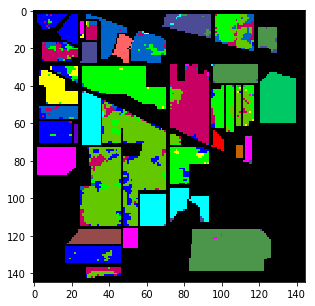

In [17]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [26]:
print("\n\tCLASSIFICATION REPORT\n\t******************************\n")
print(classification)



	CLASSIFICATION REPORT
	******************************

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        11
                 Corn-notill       0.72      0.76      0.74       357
                Corn-mintill       0.69      0.87      0.77       208
                        Corn       0.79      0.95      0.86        59
               Grass-pasture       0.99      0.95      0.97       121
                 Grass-trees       0.96      0.98      0.97       183
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00       120
                        Oats       1.00      1.00      1.00         5
              Soybean-notill       0.66      0.82      0.73       243
             Soybean-mintill       0.87      0.65      0.74       614
               Soybean-clean       0.79      0.82      0.81       148
                       Wheat    

In [27]:
print("\n\CONFUSION_METRICES\n\t******************************\n")
print(confusion)


\CONFUSION_METRICES
	******************************

[[ 11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 271  20   8   0   0   0   0   0  34  21   3   0   0   0   0]
 [  0   8 181   5   0   0   0   0   0   3   9   2   0   0   0   0]
 [  0   3   0  56   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1 115   0   0   0   0   0   0   0   0   1   4   0]
 [  0   0   0   0   0 179   0   0   0   0   0   0   0   1   3   0]
 [  0   0   0   0   0   0   7   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 120   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   5   0   0   0   0   0   0   0]
 [  0   4   4   0   1   2   0   0   0 199  29   4   0   0   0   0]
 [  0  81  52   1   0   0   0   0   0  56 400  23   0   0   1   0]
 [  0  10   5   0   0   1   0   0   0   8   1 122   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0  51   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 310   6   0]
 [  0   

In [29]:
print(Test_accuracy)

83.49590301513672
